In [44]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import matplotlib.font_manager as fm
from textwrap import wrap


prop = fm.FontProperties(fname='../plots/arial.ttf')

plt.rcParams['ps.useafm'] = True
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

from statsmodels.stats.multitest import multipletests

import sys
import os

sys.path.append(os.path.relpath("../../huygens"))
sys.path.append(os.path.relpath("../../galileo"))
import galileo as gal
import huygens as huy

# Define experiments

In [2]:
experiments = {"rpl22_oe": [
    ['LNCaP_GFP_1',
     'LNCaP_GFP_2',
     'LNCaP_GFP_3'],
    ['LNCaP_RPL22_1',
     'LNCaP_RPL22_2',
     'LNCaP_RPL22_3']
],
    "rpl22l1_oe": [
    ['CAL851_GFP_1',
     'CAL851_GFP_2',
     'CAL851_GFP_3'],
    ['CAL851_RPL22L1_1',
     'CAL851_RPL22L1_2',
     'CAL851_RPL22L1_3']
],
    "sh704": [
    ['LNCaP_shLuc_1',
     'LNCaP_shLuc_2',
     'LNCaP_shLuc_3'],
    ['LNCaP_sh704_1',
     'LNCaP_sh704_2',
     'LNCaP_sh704_3']
],
    "sh705": [
    ['LNCaP_shLuc_1',
     'LNCaP_shLuc_2',
     'LNCaP_shLuc_3'],
    ['LNCaP_sh705_1',
     'LNCaP_sh705_2',
     'LNCaP_sh705_3']
],
    "rpl22_1a1": [
    ['NCIH2110_GFP_1',
     'NCIH2110_GFP_2',
     'NCIH2110_GFP_3'],
    ['NCIH2110_RPL22-1A1_1',
     'NCIH2110_RPL22-1A1_2',
     'NCIH2110_RPL22-1A1_3']
],
    "rpl22_4a1": [
    ['NCIH2110_GFP_1',
     'NCIH2110_GFP_2',
     'NCIH2110_GFP_3'],
    ['NCIH2110_RPL22-4A1_1',
     'NCIH2110_RPL22-4A1_2',
     'NCIH2110_RPL22-4A1_3']
]
}

experiment_ids = ["rpl22_oe", "rpl22l1_oe", "sh704", "sh705", "rpl22_1a1", "rpl22_4a1"]
display_names = ["+RPL22", "+RPL22L1", "shRPL22L11", "shRPL22L12", "RPL22_ko1", "RPL22_ko2"]
display_groups = [
    ["+GFP", "+RPL22"],
    ["+GFP","+RPL22L1"],
    ["shLuc","shRPL22L1_1"],
    ["shLuc","shRPL22L1_2"],
    ["GFP_ko","RPL22_ko1"],
    ["GFP_ko","RPL22_ko2"],
]

# Load TPMS and sleuth results

In [3]:
kallisto_sleuth_path = "../data/processed/kallisto_sleuth_merge/"

rpl22_oe_genes = pd.read_csv(kallisto_sleuth_path + "rpl22_oe_genes.txt", sep="\t", index_col=0)
rpl22l1_oe_genes = pd.read_csv(kallisto_sleuth_path + "rpl22l1_oe_genes.txt", sep="\t", index_col=0)
sh704_genes = pd.read_csv(kallisto_sleuth_path + "sh704_genes.txt", sep="\t", index_col=0)
sh705_genes = pd.read_csv(kallisto_sleuth_path + "sh705_genes.txt", sep="\t", index_col=0)
rpl22_ko1_genes = pd.read_csv(kallisto_sleuth_path + "rpl22_1a1_genes.txt", sep="\t", index_col=0)
rpl22_ko2_genes = pd.read_csv(kallisto_sleuth_path + "rpl22_4a1_genes.txt", sep="\t", index_col=0)

rpl22_oe_transcripts = pd.read_csv(kallisto_sleuth_path + "rpl22_oe_transcripts.txt", sep="\t", index_col=0)
rpl22l1_oe_transcripts = pd.read_csv(kallisto_sleuth_path + "rpl22l1_oe_transcripts.txt", sep="\t", index_col=0)
sh704_transcripts = pd.read_csv(kallisto_sleuth_path + "sh704_transcripts.txt", sep="\t", index_col=0)
sh705_transcripts = pd.read_csv(kallisto_sleuth_path + "sh705_transcripts.txt", sep="\t", index_col=0)
rpl22_ko1_transcripts = pd.read_csv(kallisto_sleuth_path + "rpl22_1a1_transcripts.txt", sep="\t", index_col=0)
rpl22_ko2_transcripts = pd.read_csv(kallisto_sleuth_path + "rpl22_4a1_transcripts.txt", sep="\t", index_col=0)

# Differential expression

In [5]:
def as_si(x, ndp):
    """
    Convert a number to scientific notation

    Parameters
    ----------
    x : float
        number to convert
    ndp: float
        number of decimal places

    Returns
    -------
    x_si : string
        x formatted in scientific notation
    """

    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    x_si = r'{m:s} × $10^{{{e:d}}}$'.format(m=m, e=int(e))

    return x_si

In [55]:
control_color = "#393e46"
treatment_color = "#f67280"
alpha = 0.5

def bars(annotation_id, experiment_id, diff_results, ax=None, xlabel=None, ylabel=None):

    if ax is None:
        ax = plt.subplot(111)

    if xlabel is None:
        xlabel = experiment_id

    if ylabel is None:
        ylabel = "mRNA expression, log2(TPM + 1)"
        
    # get experiment controls and treatments
    select_abundance = diff_results.loc[annotation_id]

    controls = experiments[experiment_id][0]
    treatments = experiments[experiment_id][1]

    # extract control and treatment values
    control_values = np.log2(select_abundance[controls].astype(np.float64)+1)
    treatment_values = np.log2(
        select_abundance[treatments].astype(np.float64)+1)

    control_mean = np.mean(control_values)
    treatment_mean = np.mean(treatment_values)

    # draw bars based on means
    offset = 0.05
    width = 0.4

    control_rect = Rectangle([offset, 0],
                             width,
                             control_mean,
                             color=control_color,
                             alpha=1,
                             linewidth=0,
                             zorder=-100
                             )
    ax.add_patch(control_rect)

    treatment_rect = Rectangle([0.5+offset, 0],
                               width,
                               treatment_mean,
                               color=treatment_color,
                               alpha=1,
                               linewidth=0,
                               zorder=-100
                               )
    ax.add_patch(treatment_rect)

    # draw the points themselves
    ax.scatter([0.25-width/4, 0.25, 0.25+width/4],
               control_values,
               color="white",
               linewidth=1,
               s=32,
               edgecolor=control_color
               )
    ax.scatter([0.75-width/4, 0.75, 0.75+width/4],
               treatment_values,
               color="white",
               linewidth=1,
               s=32,
               edgecolor=treatment_color
               )

    # figure formatting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([0.25,0.75])
    ax.set_xticklabels(["",""])
    ax.set_xlabel(xlabel,rotation=45)
    ax.set_ylabel(ylabel)

    # space out axes
    ax.spines['bottom'].set_position(('axes', 0))
    ax.spines['left'].set_position(('axes', -0.25))

    # set y minimum to 0
    plt.ylim(-0.01)

    y_max = max(list(control_values)+list(treatment_values))
    
    qval = select_abundance["qval"]

    if not np.isnan(qval):

        if qval < 0.001:
            compare_text = "**"
        elif qval < 0.01:
            compare_text = "*"
        else:
            compare_text = "n.s"
            
        ax.text(0.5, 
                0.9, 
                compare_text, 
                ha="center", 
                fontsize=12,
                transform=ax.transAxes
               )

    return ax, y_max


def all_bars(annotation_id, annotation_type, legend=False):

    f, axes = plt.subplots(1, 6, sharey=True, figsize=(4, 2))

    maxes = []

    if annotation_type == "transcript":
        sleuth_sets = [rpl22_oe_transcripts,
                       rpl22l1_oe_transcripts,
                       sh704_transcripts,
                       sh705_transcripts,
                       rpl22_ko1_transcripts,
                       rpl22_ko2_transcripts
                       ]

    elif annotation_type == "gene":
        sleuth_sets = [rpl22_oe_genes,
                       rpl22l1_oe_genes,
                       sh704_genes,
                       sh705_genes,
                       rpl22_ko1_genes,
                       rpl22_ko2_genes
                       ]
        
    elif annotation_type == "splicing":
        sleuth_sets = [rpl22_oe_rmats,
                       rpl22l1_oe_rmats,
                       sh704_rmats,
                       sh705_rmats,
                       rpl22_ko1_rmats,
                       rpl22_ko2_rmats
                       ]

    for sleuth_idx, sleuth_set in enumerate(sleuth_sets):
        ax = axes[sleuth_idx]

        ax, y_max = bars(annotation_id,
                         experiment_ids[sleuth_idx],
                         sleuth_set,
                         ax=ax,
                         ylabel="")

        maxes.append(y_max)

        if sleuth_idx > 0:

            ax.spines["left"].set_visible(False)
            ax.tick_params(axis='y', which='both', right=False,
                           left=False, labelleft=False)
        
        ax.set_xticklabels(display_groups[sleuth_idx],rotation=45,ha="right")
        ax.set_xlabel("")
    
    if annotation_type == "transcript" or annotation_type == "gene":
        axes[0].set_ylabel("mRNA expression, log2(TPM+1)")
        
    elif annotation_type == "splicing":
        axes[0].set_ylabel("Exon inclusion proportion")

    plt.ylim(0, max(maxes)*1.25)

    plt.subplots_adjust(wspace=0.25)
    
    if legend:

        legend_background = "#eaeaea"

        legend_elements = [Patch(label='Control',
                                 color=control_color, alpha=1),
                           Patch(label='Treatment',
                                 color=treatment_color, alpha=1)]

        legend = plt.legend(handles=legend_elements,
                            loc='upper left', bbox_to_anchor=(1, 1),)
        frame = legend.get_frame()
        frame.set_facecolor(legend_background)
        frame.set_edgecolor(legend_background)
    
    return axes

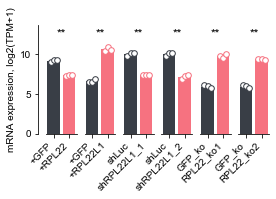

In [56]:
all_bars("ENSG00000163584","gene")

plt.savefig("../plots/RPL22L1_ENSG00000163584_expression.pdf",bbox_inches="tight",background="transparent")

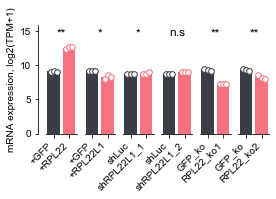

In [57]:
all_bars("ENSG00000116251","gene")

plt.savefig("../plots/RPL22_ENSG00000116251_expression.pdf",bbox_inches="tight",background="transparent")

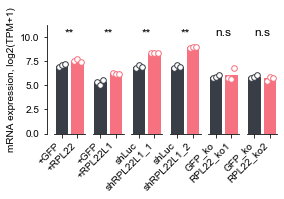

In [58]:
all_bars("ENSG00000135679","gene")

plt.savefig("../plots/MDM2_ENSG00000135679_expression.pdf",bbox_inches="tight",background="transparent")

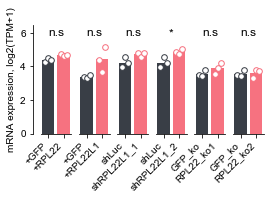

In [59]:
all_bars("ENSG00000198625","gene")

plt.savefig("../plots/MDM4_ENSG00000198625_expression.pdf",bbox_inches="tight",background="transparent")

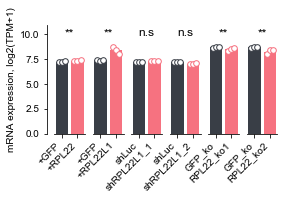

In [112]:
all_bars("ENSG00000143569","gene")

plt.savefig("../plots/UBAP2L_ENSG00000143569_expression.pdf",bbox_inches="tight",background="transparent")

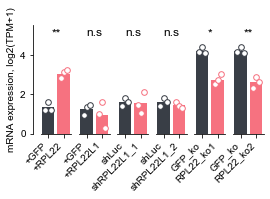

In [116]:
all_bars("ENST00000484819","transcript")

plt.savefig("../plots/UBAP2L_ENST00000484819_expression.pdf",bbox_inches="tight",background="transparent")

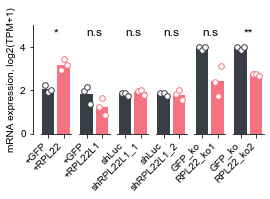

In [117]:
all_bars("ENST00000433615","transcript")

plt.savefig("../plots/UBAP2L_ENST00000433615_expression.pdf",bbox_inches="tight",background="transparent")

## Volcano plots

# Differential splicing

In [39]:
rpl22_oe_rmats = pd.read_csv("../data/processed/rmats_merge/rpl22_oe.txt",sep="\t",index_col=0)
rpl22l1_oe_rmats = pd.read_csv("../data/processed/rmats_merge/rpl22l1_oe.txt",sep="\t",index_col=0)
sh704_rmats = pd.read_csv("../data/processed/rmats_merge/sh704.txt",sep="\t",index_col=0)
sh705_rmats = pd.read_csv("../data/processed/rmats_merge/sh705.txt",sep="\t",index_col=0)
rpl22_ko1_rmats = pd.read_csv("../data/processed/rmats_merge/rpl22_ko1.txt",sep="\t",index_col=0)
rpl22_ko2_rmats = pd.read_csv("../data/processed/rmats_merge/rpl22_ko2.txt",sep="\t",index_col=0)

rpl22_oe_rmats = rpl22_oe_rmats.rename({"PValue":"pval","FDR":"qval"},axis=1)
rpl22l1_oe_rmats = rpl22l1_oe_rmats.rename({"PValue":"pval","FDR":"qval"},axis=1)
sh704_rmats = sh704_rmats.rename({"PValue":"pval","FDR":"qval"},axis=1)
sh705_rmats = sh705_rmats.rename({"PValue":"pval","FDR":"qval"},axis=1)
rpl22_ko1_rmats = rpl22_ko1_rmats.rename({"PValue":"pval","FDR":"qval"},axis=1)
rpl22_ko2_rmats = rpl22_ko2_rmats.rename({"PValue":"pval","FDR":"qval"},axis=1)

splice_types = ["A3SS","A5SS","MXE","RI","SE"]

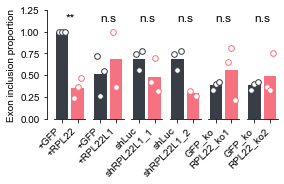

In [60]:
all_bars("UBAP2L_ENSG00000143569_154241837_154241888_154241232_154241430_154243356_154243649", 
     "splicing")

plt.savefig("../plots/UBAP2L_splicing.pdf",bbox_inches="tight",background="transparent")

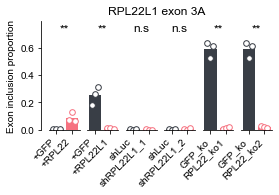

In [65]:
axes = all_bars("RPL22L1_ENSG00000163584_170585801_170585990_170585801_170585923_170586086_170586176", 
     "splicing")
plt.suptitle("RPL22L1 exon 3A")

plt.savefig("../plots/RPL22L1_3A_splicing.pdf",bbox_inches="tight",background="transparent")

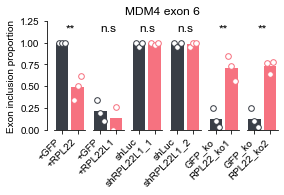

In [70]:
axes = all_bars("MDM4_ENSG00000198625_204506557_204506625_204501318_204501374_204507336_204507436", 
     "splicing")

plt.suptitle("MDM4 exon 6")
plt.savefig("../plots/MDM4_6_splicing.pdf",bbox_inches="tight",background="transparent")

## Splicing types

In [41]:
def plot_splice_types(rmats_diffs, qval_cutoff=0.01, ax=None,legend=False):
    
    if ax is None:
        ax = plt.subplot(111)

    significants = rmats_diffs.copy(
        deep=True)[rmats_diffs["qval"] < qval_cutoff]

    significants["treatment_increase"] = significants["treatment_median"] > significants["control_median"]

    significants["treatment_increase"] = significants["treatment_increase"].replace({True: "Inclusion",
                                                                                     False: "Exclusion"})

    significants = significants.groupby(
        "splice_type")["treatment_increase"].value_counts()
    significants = significants.unstack()

    significants, _ = significants.align(
        pd.Series(index=splice_types), join="right", axis=0)
    significants = significants.fillna(0)

    significants["splice_type"] = significants.index
    
    significants.columns.name = ""
    
    significants.plot(x="splice_type",
                      y=["Exclusion", "Inclusion"],
                      kind="bar",
                      cmap=mpl.colors.ListedColormap(
                          ["#dbe2ef", "#3f72af"]),
                      ax=ax,
                      stacked=True,
                      width=0.5,
                      legend=legend
                      )
    
    plt.ylabel("Frequency")
    plt.xlabel("Splice type")
    
    plt.xticks(rotation=45,ha="right")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines['left'].set_position(('axes', -0.05))

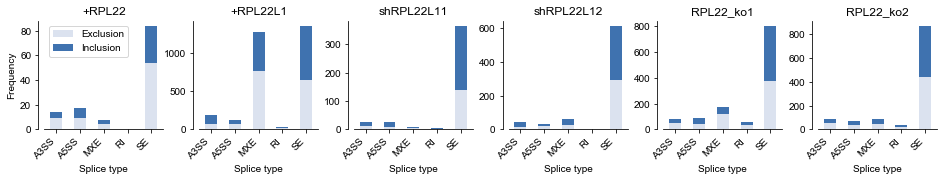

In [66]:
plt.figure(figsize=(16,2))
    
for experiment_idx, experiment in enumerate([rpl22_oe_rmats,
                                             rpl22l1_oe_rmats,
                                             sh704_rmats,
                                             sh705_rmats,
                                             rpl22_ko1_rmats,
                                             rpl22_ko2_rmats
                                            ]):

    ax = plt.subplot(1,6,experiment_idx+1)
    plot_splice_types(experiment,ax=ax,legend=experiment_idx<1)
    
    if experiment_idx > 0:
        plt.ylabel("")
        
    ax.set_title(display_names[experiment_idx])
        
plt.subplots_adjust(wspace=0.3)

plt.savefig("../plots/significant_splice_types.pdf",bbox_inches="tight",background="transparent")

# fgsea results

In [884]:
rpl22_oe_fgsea = pd.read_csv("../data/processed/fgsea_results/rpl22_oe.txt",sep="\t",index_col=0)
rpl22l1_oe_fgsea = pd.read_csv("../data/processed/fgsea_results/rpl22l1_oe.txt",sep="\t",index_col=0)
sh704_fgsea = pd.read_csv("../data/processed/fgsea_results/sh704.txt",sep="\t",index_col=0)
sh705_fgsea = pd.read_csv("../data/processed/fgsea_results/sh705.txt",sep="\t",index_col=0)

def preprocess_fgsea(fgsea):
    fgsea.sort_values(by="padj",inplace=True)
    fgsea.index = fgsea["pathway"]
    fgsea["gene_set"] = fgsea["pathway"].str.split("_").str[0]
    fgsea["direction"] = fgsea["NES"] > 0
    
preprocess_fgsea(rpl22_oe_fgsea)
preprocess_fgsea(rpl22l1_oe_fgsea)
preprocess_fgsea(sh704_fgsea)
preprocess_fgsea(sh705_fgsea)

In [1089]:
def get_top_n(fgsea, n=4):
#     positives = fgsea[fgsea["direction"]==True].head(n)
#     negatives = fgsea[fgsea["direction"]==False].head(n)

    return fgsea.head(n*2)
    
#     return pd.concat([positives,negatives],axis=0).sort_values(by="pval")

rpl22_oe_fgsea_top = get_top_n(rpl22_oe_fgsea)
rpl22l1_oe_fgsea_top = get_top_n(rpl22l1_oe_fgsea)
sh704_fgsea_top = get_top_n(sh704_fgsea)
sh705_fgsea_top = get_top_n(sh705_fgsea)

In [1109]:
fgsea = rpl22l1_oe_fgsea_top


def plot_top(fgsea_top, ax=None, legend=False):

    if ax is None:

        ax = plt.subplot(111)

    g = sns.scatterplot(
        -np.log10(fgsea_top["padj"]),
        np.arange(8),
        size=fgsea_top["size"].rename("Gene set size"),
        hue=(fgsea_top["NES"] > 0).replace(
            {True: "Upregulated", False: "Downregulated"}).rename("Expression change,\ntreatment"),
        sizes=(40, 250),
        size_norm=(0, 500),
        palette={"Upregulated": "#3f72af", "Downregulated": "#e23e57"},
        ax=ax,
        legend=legend
    )
    
    if legend:
        g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)   

    ax.set_xlim(0, plt.xlim()[1]*1.1)


    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.spines['bottom'].set_position(('axes', -0.025))
    ax.spines['left'].set_position(('axes', -0.05))

    ax.set_xlabel("-log10(q-value)")
    ax.set_yticks(np.arange(8))
    
    ylabels = fgsea_top["pathway"].apply(
        lambda x: x.replace("_", " ").capitalize())
    
    ylabels = ylabels.apply(lambda x: x.replace("Go ","").replace(" process","").capitalize())
    
    ax.set_yticklabels(ylabels)

    return ax

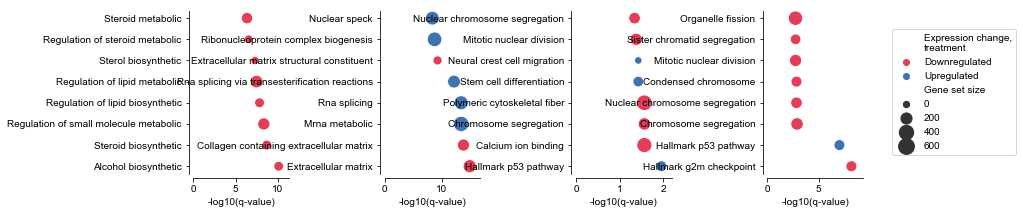

In [1110]:
plt.figure(figsize=(12,3))
plot_top(rpl22_oe_fgsea_top,plt.subplot(141))
plot_top(rpl22l1_oe_fgsea_top,plt.subplot(142))
plot_top(sh704_fgsea_top,plt.subplot(143))
plot_top(sh705_fgsea_top,plt.subplot(144),legend='brief')

plt.subplots_adjust(wspace=1)

plt.savefig("../plots/fgsea_top.pdf",bbox_inches="tight",background="transparent")